# This notebook assigns classes to the HSC objects with catalog cross matching

You will need the HSC DR3 object catalogs.  To get clean objects in the Deep/UltraDeep fields, use the SQL query below

-- Note that in practice you should not use the pixelflags marked by /**/  
-- in searching deep/udeep fields though they are useful in wide fields.  
-- In fact, the longer the total exposure time is,  
-- the more likely pixels are affected by clipping, cosmic rays, and interpolation.  
-- If you exclude objects affected by these things in deep/udeep fields,  
-- you will miss many wanted objects.  

SELECT  
        object_id  
      , ra  
      , dec  
      , g_cmodel_mag  
      , g_cmodel_magerr  
      , r_cmodel_mag  
      , r_cmodel_magerr  
      , i_cmodel_mag  
      , i_cmodel_magerr  
      , z_cmodel_mag  
      , z_cmodel_magerr  
      , y_cmodel_mag  
      , y_cmodel_magerr  
      , g_psfflux_mag  
      , g_psfflux_magerr   
      , r_psfflux_mag  
      , r_psfflux_magerr  
      , i_psfflux_mag  
      , i_psfflux_magerr  
      , z_psfflux_mag  
      , z_psfflux_magerr  
      , y_psfflux_mag  
      , y_psfflux_magerr  
      , a_g  
      , a_r  
      , a_i  
      , a_z  
      , a_y  
    FROM  
        pdr3_dud_rev.forced  
        JOIN pdr3_dud_rev.forced2 USING (object_id)  
    WHERE  
        isprimary  
    AND NOT g_sdsscentroid_flag  
    AND NOT r_sdsscentroid_flag  
    AND NOT i_sdsscentroid_flag  
    AND NOT z_sdsscentroid_flag  
    AND NOT y_sdsscentroid_flag  
    AND NOT g_pixelflags_edge  
    AND NOT r_pixelflags_edge  
    AND NOT i_pixelflags_edge  
    AND NOT z_pixelflags_edge  
    AND NOT y_pixelflags_edge  
    --AND NOT g_pixelflags_interpolatedcenter /**/  
    --AND NOT r_pixelflags_interpolatedcenter /**/  
    --AND NOT i_pixelflags_interpolatedcenter /**/  
    --AND NOT z_pixelflags_interpolatedcenter /**/  
    --AND NOT y_pixelflags_interpolatedcenter /**/  
    AND NOT g_pixelflags_saturatedcenter  
    AND NOT r_pixelflags_saturatedcenter  
    AND NOT i_pixelflags_saturatedcenter  
    AND NOT z_pixelflags_saturatedcenter  
    AND NOT y_pixelflags_saturatedcenter  
    --AND NOT g_pixelflags_crcenter /**/  
    --AND NOT r_pixelflags_crcenter /**/  
    --AND NOT i_pixelflags_crcenter /**/   
    --AND NOT z_pixelflags_crcenter /**/  
    --AND NOT y_pixelflags_crcenter /**/  
    AND NOT g_pixelflags_bad  
    AND NOT r_pixelflags_bad  
    AND NOT i_pixelflags_bad  
    AND NOT z_pixelflags_bad  
    AND NOT y_pixelflags_bad  
    AND NOT g_cmodel_flag  
    AND NOT r_cmodel_flag  
    AND NOT i_cmodel_flag  
    AND NOT z_cmodel_flag  
    AND NOT y_cmodel_flag  
;  

-- * Flags pixelflags_* vs. pixelflags_*center  
--   "any" (without "center") flags are set when any of the pixels in the object's  
--   footprint is bad. The critera "NOT pixelflags_*" are too strict. Since most of  
--   the object's flux comes from its center, it is usually safe to accept bad  
--   conditions in the outskirt of the object.  
--  
-- * Condition "isprimary" is true  
--   - no children  
--   - in the inner region of a coadd patch (detect_ispatchinner)  
--   - in the inner region of a coadd tract (detect_istractinner)  
--   - not "detected" in a pseudo-filter (see config.pseudoFilterList)  

In [1]:
# In case you need to point to pre-existing scarlet install
import sys
sys.path.insert(1, '/home/g4merz/deblend/astrodet/')
#sys.path.insert(1, '/home/paleo2/.conda/envs/astro-det-scarlet2/lib/python3.7/site-packages/scarlet-1.0.1+gfde109a-py3.7-linux-ppc64le.egg/')


In [4]:
# Standard imports
import sys, os
import numpy as np
import time
import glob

import scarlet
import sep
from skimage.util.shape import view_as_blocks
from scipy import stats as scistats


import pandas as pd

import astropy.io.fits as fits
from astropy.wcs import WCS
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.coordinates import SkyCoord
import astropy.units as u

from scarlet.display import AsinhMapping
from astropy.nddata import Cutout2D

# Astrodet imports
import astrodet.scarlet_update as sc
#import astrodet.scarlet as sc
from astrodet.hsc import get_tract_patch_from_coord, get_hsc_data#, get_hsc_DR3_data

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm


import detectron2
from detectron2.utils.visualizer import Visualizer
from detectron2.structures import BoxMode
import cv2

from astrodet import astrodet as toolkit


# use a better colormap and don't interpolate the pixels
#matplotlib.rc('image', cmap='gray', interpolation='none', origin='lower')


Make a list of sky coords of every source in every scarlet image and turn into astropy SkyCoord (catalog)  

Grab the HSC catalogs and make a SkyCoord list(c)  

Search for matches within 1'' using  `astropy search_around_sky()`

Use indices to set class of scarlet catalog objects from extendedness of each HSC catalog object  



## Load in the HSC object catalog

In [ ]:
dall=pd.read_csv('/home/g4merz/deblend/data/all_cat_mags_primary.csv.gz')
ra_all = dall['ra'][:].values
dec_all = dall['dec'][:].values
allcatalog = SkyCoord(ra=ra_all*u.degree, dec=dec_all*u.degree)

## The functions below will return the image cutouts and their coordinates.  
This lets us calculate the coordinates of each object and then cross match

In [7]:
def read_image(datas, normalize='lupton', stretch=5, Q=10, m=0, ceil_percentile=99.995, dtype=np.uint8):
    # Read image
    
    g = datas[0]
    r = datas[1]
    z = datas[2]
    
    # Contrast scaling / normalization
    I = (z + r + g)/3.0
    
    length, width = g.shape
    image = np.empty([length, width, 3], dtype=dtype)
    
    # Options for contrast scaling
    if normalize.lower() == 'lupton':
        z = z*np.arcsinh(stretch*Q*(I - m))/(Q*I)
        r = r*np.arcsinh(stretch*Q*(I - m))/(Q*I)
        g = g*np.arcsinh(stretch*Q*(I - m))/(Q*I)
    elif normalize.lower() == 'zscore':
        Isigma = I*np.mean([np.nanstd(g), np.nanstd(r), np.nanstd(z)])
        z = (z - np.nanmean(z) - m)/Isigma
        r = (r - np.nanmean(r) - m)/Isigma
        g = (g - np.nanmean(g) - m)/Isigma
    elif normalize.lower() == 'linear':
        z = (z - m)/I
        r = (r - m)/I
        g = (g - m)/I
    else:
        print('Normalize keyword not recognized.')

    max_RGB = np.nanpercentile([z, r, g], ceil_percentile)
    # avoid saturation
    r = r/max_RGB; g = g/max_RGB; z = z/max_RGB

    # Rescale to 0-255 for dtype=np.uint8
    max_dtype = np.iinfo(dtype).max
    r = r*max_dtype
    g = g*max_dtype
    z = z*max_dtype

    # 0-255 RGB image
    image[:,:,0] = z # R
    image[:,:,1] = r # G
    image[:,:,2] = g # B
    
    return image

In [8]:
def get_hsc_DR3_data(dirpath, filters=['g','r','i'], tract=10054, patch=[0,0], coord=None, cutout_size=[128, 128]):
    """
    Get HSC data given tract/patch info or SkyCoord
    
    Parameters
    ----------
    dirpath : str
        Path to HSC image file directory
    filters : list 
        A list of filters for your images. Default is ['g', 'r', 'i'].
    tract  : int
        An integer used for specifying the tract. Default is 10054
    patch : [int, int]
        Patch #,#. Default is [0,0]
    coord  : SkyCoord
        Astropy SkyCoord, when specified, overrides tract/patch info and attempts to lookup HSC filename from ra, dec. 
        Default is None
    cutout_size: [int, int]
        Size of cutout to use (set to None for no cutting). Default is [128, 128]
        
    The image filepath is in the form:
        {dirpath}/deepCoadd/HSC-{filter}/{tract}/{patch[0]},{patch[1]}/calexp-HSC-{filter}-{tract}-{patch[0]},{patch[1]}.fits
    
    Returns
    -------
    data : ndarray
        HSC data array with dimensions [filters, N, N]
    """
    
    filters = [f.upper() for f in filters]
    
    #if coord is not None:
    #    print("Overriding tract/patch info and looking for HSC file at requested coordinates.")
    #    tract, patch = get_tract_patch_from_coord(coord)
        
    datas = []

    for f in filters:
        filepath = os.path.join(dirpath, f'HSC-{f}/calexp-HSC-{f}-{tract}-{patch[0]},{patch[1]}.fits')
        
        #print(f'Loading "{filepath}".')
        #try:
        
        with fits.open(filepath) as obs_hdul:
        #obs_hdul = fits.open(filepath)
            data = obs_hdul[1].data
            wcs = WCS(obs_hdul[1].header)
        
        cutout =None
        
        # Cutout data at center of patch (coord=None) or at coord (if specified)
        if cutout_size is not None:
            # Use coord for center position if specified
            if coord is None:
                shape = np.shape(data)
                position = (shape[0]/2, shape[1]/2)
            else:
                position = coord
            #data = Cutout2D(data, position=position, size=cutout_size, wcs=wcs).data
            cutout = Cutout2D(data, position=position, size=cutout_size, wcs=wcs)
            data = cutout.data

        datas.append(data)
        #except:
        #    print('Missing filter ', f)
            

    return np.array(datas), cutout

In [9]:
def get_centers(sub_shape):
    centers=[]
    for i in range(4):
        for j in range(4):
            #print(sub_shape[1]*i)
            s=np.array(sub_shape)/2 + (sub_shape[0]*j, sub_shape[1]*i)
            centers.append(s)
            
    return centers

In [10]:

def get_cutout(tract,patch,sp,plot=True):

    nblocks=4
    nfilters=3
    
    #Loading "/home/g4merz/deblend/data/raw_HSC_DR3/HSC-G/calexp-HSC-G-8765-2,3.fits".
    hsc_dirpath = '/home/g4merz/deblend/data/raw_HSC_DR3/'

    dat,cutout = get_hsc_DR3_data(hsc_dirpath,tract=tract,patch=patch,coord=None,cutout_size=None)
    print(dat.shape)
    block_size = [dat.shape[1]//nblocks, dat.shape[2]//nblocks]

    datas_blocks = view_as_blocks(dat, block_shape=(nfilters, block_size[0], block_size[1]))
    
    sub_shape = datas_blocks.shape[-2:]

    #review this code
    centers = get_centers(sub_shape[::-1])
    #centers = get_centers(sub_shape)

    coord=centers[sp]

    datsm,cutout = get_hsc_DR3_data(hsc_dirpath,tract=tract,patch=patch,coord=coord,cutout_size=sub_shape)
    #datas_blocks = datas_blocks.reshape(nblocks**2, nfilters, block_size[0], block_size[1])
    #datas = datas_blocks[sp,:,:,:]
    if plot:
        fig,ax = plt.subplots(1,2,figsize=(10,10))

        ax[0].imshow(read_image(dat),origin='lower')
        cutout.plot_on_original(ax[0],color='white')
        ax[1].imshow(read_image(datsm),origin='lower')

        #ax[0].axis('off')
        #ax[1].axis('off')
        plt.tight_layout()
    
    return cutout

(3, 4200, 4200)


/tmp/ipykernel_3654218/1343913078.py:16: RuntimeWarning: invalid value encountered in true_divide
  z = z*np.arcsinh(stretch*Q*(I - m))/(Q*I)
/tmp/ipykernel_3654218/1343913078.py:17: RuntimeWarning: invalid value encountered in true_divide
  r = r*np.arcsinh(stretch*Q*(I - m))/(Q*I)
/tmp/ipykernel_3654218/1343913078.py:18: RuntimeWarning: invalid value encountered in true_divide
  g = g*np.arcsinh(stretch*Q*(I - m))/(Q*I)


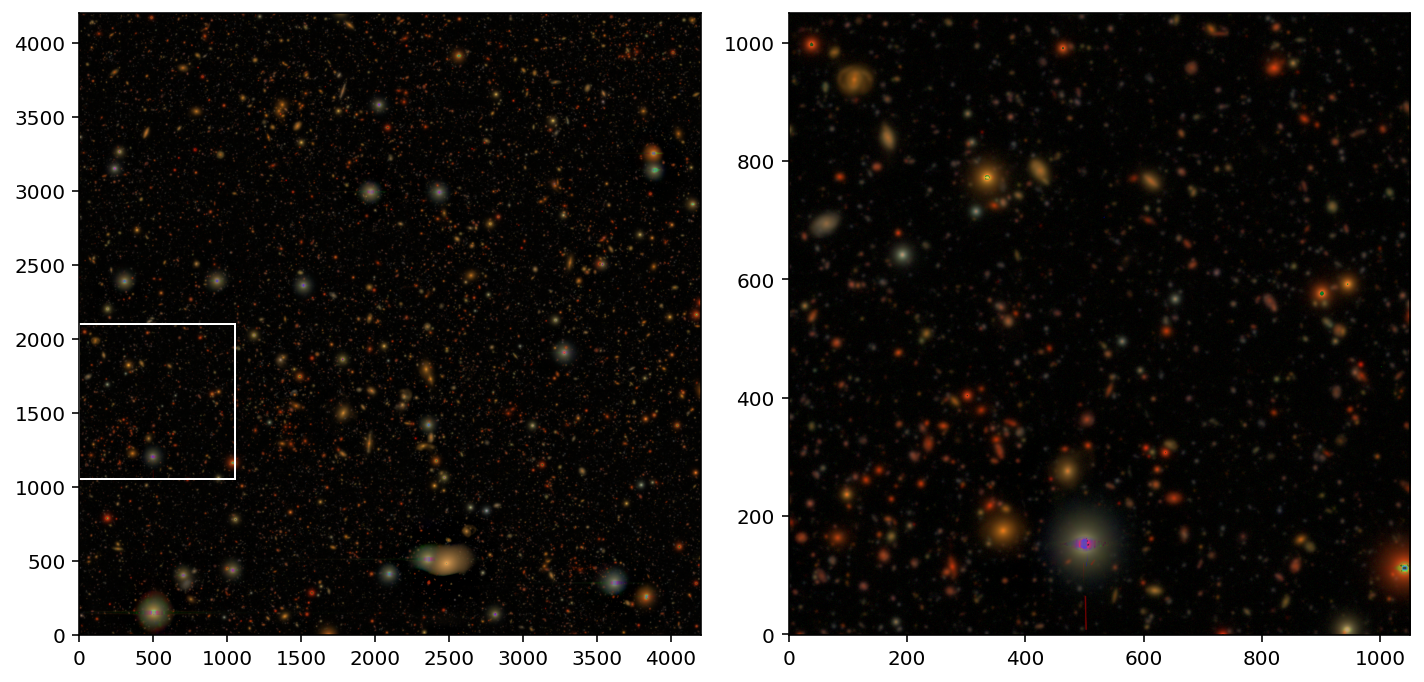

In [11]:
#tract=8766
#patch = [0,0]
#sp=1
tract=9813
patch=[5,4]
sp=4
cutout= get_cutout(tract,patch,sp,plot=True)
#plt.savefig('/home/g4merz/deblend/plots/cutout_ex.png')

### Now we can return a list of RA,DEC coordinates for every detected object in an image

In [12]:
def return_sp_cat(filename,f='G'):
    #im = fits.open(filename)
    
    with fits.open(filename) as im:

        s = filename.split(f'{f}-')[1].split('.fits')[0]
        tract, patch,sp = s.split('-')
        tract = int(tract)
        patch = tuple(map(int, patch.split(',')))
        sp = int(sp[1:-14])


        cutout = get_cutout(tract,patch,sp,plot=False)

        ras=[]
        decs=[]

        for source in im[1:]:
            coords = source.header['BBOX'].split(',')
            x = int(coords[0])
            y = int(coords[1])
            skycoords=cutout.wcs.pixel_to_world(x,y)
            ras.append(skycoords.ra.degree)
            decs.append(skycoords.dec.degree)
            
    return ras,decs
    

In [13]:
%%time
fi='/home/shared/hsc/HSC/HSC_DR3/data/train/G-8766-0,0-c5_scarlet_model.fits'
maskfile='/home/shared/hsc/HSC/HSC_DR3/data/train/I-8766-0,0-c5_scarlet_segmask.fits'
#testmask = fits.open(maskfile)
ras,decs = return_sp_cat(fi)
#c = SkyCoord(ra=ras*u.degree, dec=decs*u.degree)
#idx, d2d, d3d = c.match_to_catalog_sky(allcatalog)
#fits.close(maskfile)


(3, 4100, 4100)
CPU times: user 4.6 s, sys: 70.1 ms, total: 4.67 s
Wall time: 4.76 s


In [39]:
%%time
ras_train = []
decs_train = []
for modelf in (files_train[0:50]):
    ras, decs = return_sp_cat(modelf)
    ras_train.append(ras)
    decs_train.append(decs)

CPU times: user 8min 13s, sys: 4.96 s, total: 8min 18s
Wall time: 8min 27s


In [21]:

def return_model_cat(args):
    modpath,segpath,dirpath = args

    print('Running on ', segpath)

    oG,oR,oI, model = sc.return_model_objects(modpath,stringcap=14,dirpath=dirpath)
    sources = []
    #masks = []
    catalogs =[]

    #bkgmod = sep.Background(np.sum(model,axis=0))
    bkgmod = sep.Background(model[0])
    exceptions=[]
    #for i in range(0,1):
    for i in range(len(oG)):
        oG_new, oR_new, oI_new = sc.return_spliced_sources(oG[i],oR[i],oI[i])
        source = np.zeros((3,)+oG_new.shape)
        try:
            source[0] = oG_new
            source[1] = oR_new
            source[2] = oI_new
            sources.append(source)
        except ValueError:
            print('Error with source ', i, 'on file ', modpath)
            continue
        #maskthresh = bkg_rms.mean()*5.0
        #maskthresh = bkg.globalrms*1.2

        dt = source

        # Detection image as the sum over all images
        #model_det = np.sum(dt, axis=0)
    
        #calculate band mag
        model_det = source[2]
        
        lvl_segmask = 5.0
        #maskthresh = 10.0
        bkgim = sep.Background(model_det)
        try:
            catalog,mask = sep.extract(model_det, lvl_segmask, err=bkgmod.globalrms, segmentation_map=True)
        except:
            print('Exception with source %d in file ' %i, modpath)
            exceptions.append(i)
            mask = np.zeros_like(model_det)
            mask[model_det>lvl_segmask*bkgmod.globalrms] = 1
            catalog=[]

        # If more than 1 source is detected for some reason (e.g. artifacts)
        if len(catalog) > 1:
            print('More than 1 source for object ', i, ' in file ', modpath)
            # keep the brightest
            idx = np.argmax([c['cflux'] for c in catalog])
            catalog = catalog[idx]
            mask[mask!=idx]=0

        #masks.append(mask)
        catalogs.append(catalog)
    return catalogs




In [14]:
import json
dirpath = '/home/shared/hsc/HSC/HSC_DR3/data/' # Path to dataset
output_dir = '/home/shared/hsc/HSC/HSC_DR3/models/'

dataset_names = ['train', 'test', 'val'] 

def get_data_from_json(file):
    # Opening JSON file
    with open(file, 'r') as f:
        data = json.load(f)
    return data

datadir='/home/shared/hsc/HSC/HSC_DR3/data/'
t0 = time.time()
dataset_dicts = {}
for i, d in enumerate(dataset_names):
    print(f'Loading {d}')
    dataset_dicts[d] = get_data_from_json(datadir+dataset_names[i]+'_sample.json')
    
print('Took ', time.time()-t0, 'seconds for samples')

Loading train
Loading test
Loading val
Took  7.8847246170043945 seconds for samples


In [15]:
files_train = []
maskfiles_train = []

for d in dataset_dicts['train']:
    filename = d['filename_G']
    s = filename.split(f'G-')[1].split('.fits')[0]
    tract, patch,sp = s.split('-')
    tract = int(tract)
    patch = tuple(map(int, patch.split(',')))
    sp = int(sp[1:-12])

    file = f'/home/shared/hsc/HSC/HSC_DR3/data/train/G-{tract}-{patch[0]},{patch[1]}-c{sp}_scarlet_model.fits'
    maskfile = f'/home/shared/hsc/HSC/HSC_DR3/data/train/I-{tract}-{patch[0]},{patch[1]}-c{sp}_scarlet_segmask.fits'

    files_train.append(file)
    maskfiles_train.append(maskfile)
    
files_test = []
maskfiles_test = []

for d in dataset_dicts['test']:
    filename = d['filename_G']
    s = filename.split(f'G-')[1].split('.fits')[0]
    tract, patch,sp = s.split('-')
    tract = int(tract)
    patch = tuple(map(int, patch.split(',')))
    sp = int(sp[1:-12])

    file = f'/home/shared/hsc/HSC/HSC_DR3/data/test/G-{tract}-{patch[0]},{patch[1]}-c{sp}_scarlet_model.fits'
    maskfile = f'/home/shared/hsc/HSC/HSC_DR3/data/test/I-{tract}-{patch[0]},{patch[1]}-c{sp}_scarlet_segmask.fits'

    files_test.append(file)
    maskfiles_test.append(maskfile)

    
files_val = []
maskfiles_val = []

for d in dataset_dicts['val']:
    filename = d['filename_G']
    s = filename.split(f'G-')[1].split('.fits')[0]
    tract, patch,sp = s.split('-')
    tract = int(tract)
    patch = tuple(map(int, patch.split(',')))
    sp = int(sp[1:-12])

    file = f'/home/shared/hsc/HSC/HSC_DR3/data/val/G-{tract}-{patch[0]},{patch[1]}-c{sp}_scarlet_model.fits'
    maskfile = f'/home/shared/hsc/HSC/HSC_DR3/data/train/I-{tract}-{patch[0]},{patch[1]}-c{sp}_scarlet_segmask.fits'
    files_val.append(file)
    maskfiles_val.append(maskfile)
maskfiles = [maskfiles_train,maskfiles_test,maskfiles_val]


In [16]:
def scheme_2(gext,rext,iext,imag):
    if np.isnan(gext) or np.isnan(rext) or np.isnan(iext):
        e=np.array([gext,rext,iext])
        bad=np.isnan(e)
        good=~bad
        sbad=sum(bad)
        if sbad>=3:
            catid =2
        else:
            sgood=sum(e[good])
            if sgood>=1:
                catid=1
            else:
                catid=0

    else:
        totext = gext+rext+iext

        if totext>=1:
            catid=1
        else:
            catid=0

    return catid


###  Old class assginment scheme based on nearest object

In [17]:
def assign_classes(filename,dset='train'):
    s = filename.split(f'G-')[1].split('.fits')[0]
    tract, patch,sp = s.split('-')
    tract = int(tract)
    patch = tuple(map(int, patch.split(',')))
    sp = int(sp[1:-14])

    maskfile = f'/home/shared/hsc/HSC/HSC_DR3/data/{dset}/I-{tract}-{patch[0]},{patch[1]}-c{sp}_scarlet_segmask.fits'
    #maskfile = filename

    ras,decs = return_sp_cat(filename)
    c = SkyCoord(ra=ras*u.degree, dec=decs*u.degree)
    idx, d2d, d3d = c.match_to_catalog_sky(allcatalog)

    print('Assigning classes ', filename)


    with fits.open(maskfile, mode='update') as hdul:

    # Change something in hdul.

        for i,ind in enumerate(idx):
            ext = dall.loc[ind]
            gext=ext['g_extendedness_value']
            rext=ext['r_extendedness_value']
            iext=ext['i_extendedness_value']
            oid = dall['# object_id'][ind]
            imag = ext['i_cmodel_mag']

            #catid1 = scheme_1(gext,rext,iext,imag)
            catid2 = scheme_2(gext,rext,iext,imag)
            #catid3 = scheme_3(gext,rext,iext,imag)

            if np.isnan(imag) or np.isinf(imag):
                imag=0

            #hdul[1+i].header.set('cat_id'+suffix,catid1)
            hdul[1+i].header.set('cat_id2'+suffix,catid2)
            #hdul[1+i].header.set('cat_id3'+suffix,catid3)
            hdul[1+i].header.set('imag',imag)
            hdul[1+i].header.set('hsc_oid',oid)


        hdul.flush()  # changes are written back to original.fits


### New class assignment based on distance and mag

In [18]:
    
def assign_classes_new(filename,dset='train',seplim=1.0):
    s = filename.split(f'G-')[1].split('.fits')[0]
    tract, patch,sp = s.split('-')
    tract = int(tract)
    patch = tuple(map(int, patch.split(',')))
    sp = int(sp[1:-14])
    
    maskfile = f'/home/shared/hsc/HSC/HSC_DR3/data/{dset}/I-{tract}-{patch[0]},{patch[1]}-c{sp}_scarlet_segmask.fits'
    #maskfile = filename
    
    ras,decs = return_sp_cat(filename)
    cats = return_model_cat((filename,maskfile,dirpath))
    
    c = SkyCoord(ra=ras*u.degree, dec=decs*u.degree)
    idx, d2d, d3d = c.match_to_catalog_sky(allcatalog)
    idxc, idxcatalog, d2ds, d3ds = allcatalog.search_around_sky(c, seplim*u.arcsec)
    allcatalog_inds =[]     

    for i,cat in enumerate(cats):
        hsc_matches = np.where(idxc==i)[0]
        
        if len(cat)==0:
            allcatalog_ind=-1
            allcatalog_inds.append(allcatalog_ind)
            continue
        
        flux = cat['cflux']
        imag = 27-2.5*np.log10(flux)
        hsc_imag = dall.loc[idxcatalog[hsc_matches]]['i_cmodel_mag'].values
        
        if hsc_matches.size==0:
            #print('No matches at ', i, ' within one arcsecond, taking nearest neighbor')
            print('No matches at ', i, ' within one arcsecond, remove annotation')
            #allcatalog_ind = idx[i]
            allcatalog_ind=-1
            allcatalog_inds.append(allcatalog_ind)
            continue

        if imag.size==0:
            #allcatalog_ind = idx[i]
            allcatalog_ind=-1
            allcatalog_inds.append(allcatalog_ind)
            continue
            
        magdiffs = abs(np.subtract(imag,hsc_imag))

        if np.isnan(magdiffs).any():
            #print('NaN mag in HSC catalog, taking nearest neighbor')
            print('NaN mag in HSC catalog, skipping annotation')
            #allcatalog_ind = idx[i]
            allcatalog_ind=-1
            allcatalog_inds.append(allcatalog_ind)
            continue

        indmin = np.argmin(magdiffs)

        if magdiffs[indmin]>1:
            #print(f'Magnitude difference is greater than 1 at {i}, taking nearest neighbor')
            print(f'Magnitude difference is greater than 1 at {i}, skipping annotation')

            #allcatalog_ind = idx[i]
            allcatalog_ind=-1
            allcatalog_inds.append(allcatalog_ind)
            continue
        

        allcatalog_ind = idxcatalog[hsc_matches[indmin]]
        allcatalog_inds.append(allcatalog_ind)


    with fits.open(maskfile, mode='update') as hdul:

    # Change something in hdul.
   
        for i,ind in enumerate(allcatalog_inds):
            if ind ==-1:
                catid=-1
            
            else:
                ext = dall.loc[ind]
                gext=ext['g_extendedness_value']
                rext=ext['r_extendedness_value']
                iext=ext['i_extendedness_value']
                zext=ext['z_extendedness_value']
                yext=ext['y_extendedness_value']
                imag = ext['i_cmodel_mag']
                
                catid = scheme_2(gext,rext,iext,imag)
                if catid==2:
                    print('Other at ', i)

            hdul[1+i].header.set('test_id',catid)
            
            #hdul[1+i].header.set('cat_id3',catid3)

        hdul.flush()  # changes are written back to original.fits

    
    

## Run and visualize

In [22]:
%%time
#want to test on a subpatch that is completely covered by HST catalog
dirpath ='/home/shared/hsc/HSC/HSC_DR3/data/train/'
dset='train'
qind=669

d2ds=assign_classes_new(files_train[qind],dset=dset)


(3, 4200, 4200)
Running on  /home/shared/hsc/HSC/HSC_DR3/data/train/I-9813-2,2-c13_scarlet_segmask.fits
Magnitude difference is greater than 1 at 3, skipping annotation
Magnitude difference is greater than 1 at 4, skipping annotation
Magnitude difference is greater than 1 at 15, skipping annotation
Magnitude difference is greater than 1 at 21, skipping annotation
Magnitude difference is greater than 1 at 24, skipping annotation
Magnitude difference is greater than 1 at 26, skipping annotation
Magnitude difference is greater than 1 at 27, skipping annotation
Magnitude difference is greater than 1 at 28, skipping annotation
Magnitude difference is greater than 1 at 30, skipping annotation
Magnitude difference is greater than 1 at 32, skipping annotation
Magnitude difference is greater than 1 at 34, skipping annotation
Magnitude difference is greater than 1 at 42, skipping annotation
Magnitude difference is greater than 1 at 44, skipping annotation
Magnitude difference is greater than 1 a

CPU times: user 27.9 s, sys: 330 ms, total: 28.3 s
Wall time: 28.5 s


Now that we have the classes assigned, we can visualize

In [23]:

sd=[]
filenames_dict_single = {}
filenames_dict_single['filters'] = ['g', 'r', 'i']
for f in filenames_dict_single['filters']:
    filenames_dict_single[f] = {}
    # List of image files in the dataset
    #Yufeng dec/21  [Errno 2] No such file or directory: '/home/shared/hsc/test/G-I-8525-4,5-c5_scarlet_img'
    #filenames_dict[f]['img'] = [os.path.join(data_path, f'{f.upper()}-{tract_patch}_scarlet_img.fits') for tract_patch in s]
    #Yufeng jan 18 f.upper() indicates filter, tract_patch[1:] removes the default I band in the front
    filenames_dict_single[f]['img'] = [dataset_dicts[dset][qind]['filename_%s' %f.upper()]]
    # List of mask files in the dataset
    #Yufeng jan 18 all mask files are in the I band
    filenames_dict_single[f]['mask'] = [maskfiles_train[qind]]
sd.append(filenames_dict_single)
print(sd)

[{'filters': ['g', 'r', 'i'], 'g': {'img': ['/home/shared/hsc/HSC/HSC_DR3/data/train/G-9813-2,2-c13_scarlet_img.fits'], 'mask': ['/home/shared/hsc/HSC/HSC_DR3/data/train/I-9813-2,2-c13_scarlet_segmask.fits']}, 'r': {'img': ['/home/shared/hsc/HSC/HSC_DR3/data/train/R-9813-2,2-c13_scarlet_img.fits'], 'mask': ['/home/shared/hsc/HSC/HSC_DR3/data/train/I-9813-2,2-c13_scarlet_segmask.fits']}, 'i': {'img': ['/home/shared/hsc/HSC/HSC_DR3/data/train/I-9813-2,2-c13_scarlet_img.fits'], 'mask': ['/home/shared/hsc/HSC/HSC_DR3/data/train/I-9813-2,2-c13_scarlet_segmask.fits']}}]


In [24]:
def get_astro_dicts(filename_dict):
    
    """
    This needs to be customized to your training data format
    
    """
        
    dataset_dicts = []
    filters = list(filename_dict.keys())
    #yufeng april5: why only 1st filter
    f = filename_dict['filters'][0] # Pick the 1st filter for now
    
    # Filename loop
    for idx, (filename_img, filename_mask) in enumerate(zip(filename_dict[f]['img'], filename_dict[f]['mask'])):
        record = {}

        # Open FITS image of first filter (each should have same shape)
        with fits.open(filename_img, memmap=False, lazy_load_hdus=False) as hdul:
            height, width = hdul[0].data.shape
            
        # Open each FITS mask image
        with fits.open(filename_mask, memmap=False, lazy_load_hdus=False) as hdul:
            hdul = hdul[1:]
            sources = len(hdul)
            # Normalize data
            data = [hdu.data for hdu in hdul]
            #category_ids = [hdu.header["HST_ID"] for hdu in hdul]
            #category_ids = [hdu.header["CAT_ID2p"] for hdu in hdul]
            category_ids = [hdu.header["CAT_ID2p"] for hdu in hdul]
            
            ellipse_pars = [hdu.header["ELL_PARM"] for hdu in hdul]
            bbox = [list(map(int, hdu.header["BBOX"].split(','))) for hdu in hdul]
            area = [hdu.header["AREA"] for hdu in hdul]

        # Add image metadata to record (should be the same for each filter)
        for f in filename_dict['filters']:
            record[f"filename_{f.upper()}"] = filename_dict[f]['img'][idx]
        # Assign file_name
        record[f"file_name"] = filename_dict[filename_dict['filters'][0]]['img'][idx]
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
        objs = []

        # Generate segmentation masks from model
        for i in range(sources):
            image = data[i]
            # Why do we need this?
            if len(image.shape) != 2:
                print(i,'check')
                continue
            height_mask, width_mask = image.shape
            # Create mask from threshold
            mask = data[i]
            # Smooth mask
            #mask = cv2.GaussianBlur(mask, (9,9), 2)
            x,y,w,h = bbox[i] # (x0, y0, w, h)

            # https://github.com/facebookresearch/Detectron/issues/100
            contours, hierarchy = cv2.findContours((mask).astype(np.uint8), cv2.RETR_TREE,
                                                        cv2.CHAIN_APPROX_SIMPLE)
            segmentation = []
            for contour in contours:
                # contour = [x1, y1, ..., xn, yn]
                contour = contour.flatten()
                if len(contour) > 4:
                    contour[::2] += (x-w//2)
                    contour[1::2] += (y-h//2)
                    segmentation.append(contour.tolist())
            # No valid countors
            if len(segmentation) == 0:
                continue

            # Add to dict
            obj = {
                "bbox": [x-w//2, y-h//2, w, h],
                "area": w*h,
                "bbox_mode": BoxMode.XYWH_ABS,
                "segmentation": segmentation,
                "category_id": category_ids[i],
                "ellipse_pars": ellipse_pars[i]
            }
            objs.append(obj)

        record["annotations"] = objs
        dataset_dicts.append(record)
            
    return dataset_dicts

In [25]:
single_dect_dict = get_astro_dicts(filenames_dict_single)
print()
print(len(single_dect_dict[0]['annotations']))

print()
anew = [ann for ann in single_dect_dict[0]['annotations'] if ann['category_id'] not in [2,-1]]
single_dect_dict[0]['annotations'] = anew
print(len(single_dect_dict[0]['annotations']))


761

759


['/home/shared/hsc/HSC/HSC_DR3/data/train/G-9813-2,2-c13_scarlet_img.fits', '/home/shared/hsc/HSC/HSC_DR3/data/train/R-9813-2,2-c13_scarlet_img.fits', '/home/shared/hsc/HSC/HSC_DR3/data/train/I-9813-2,2-c13_scarlet_img.fits']


(-0.5, 1049.5, 1049.5, -0.5)

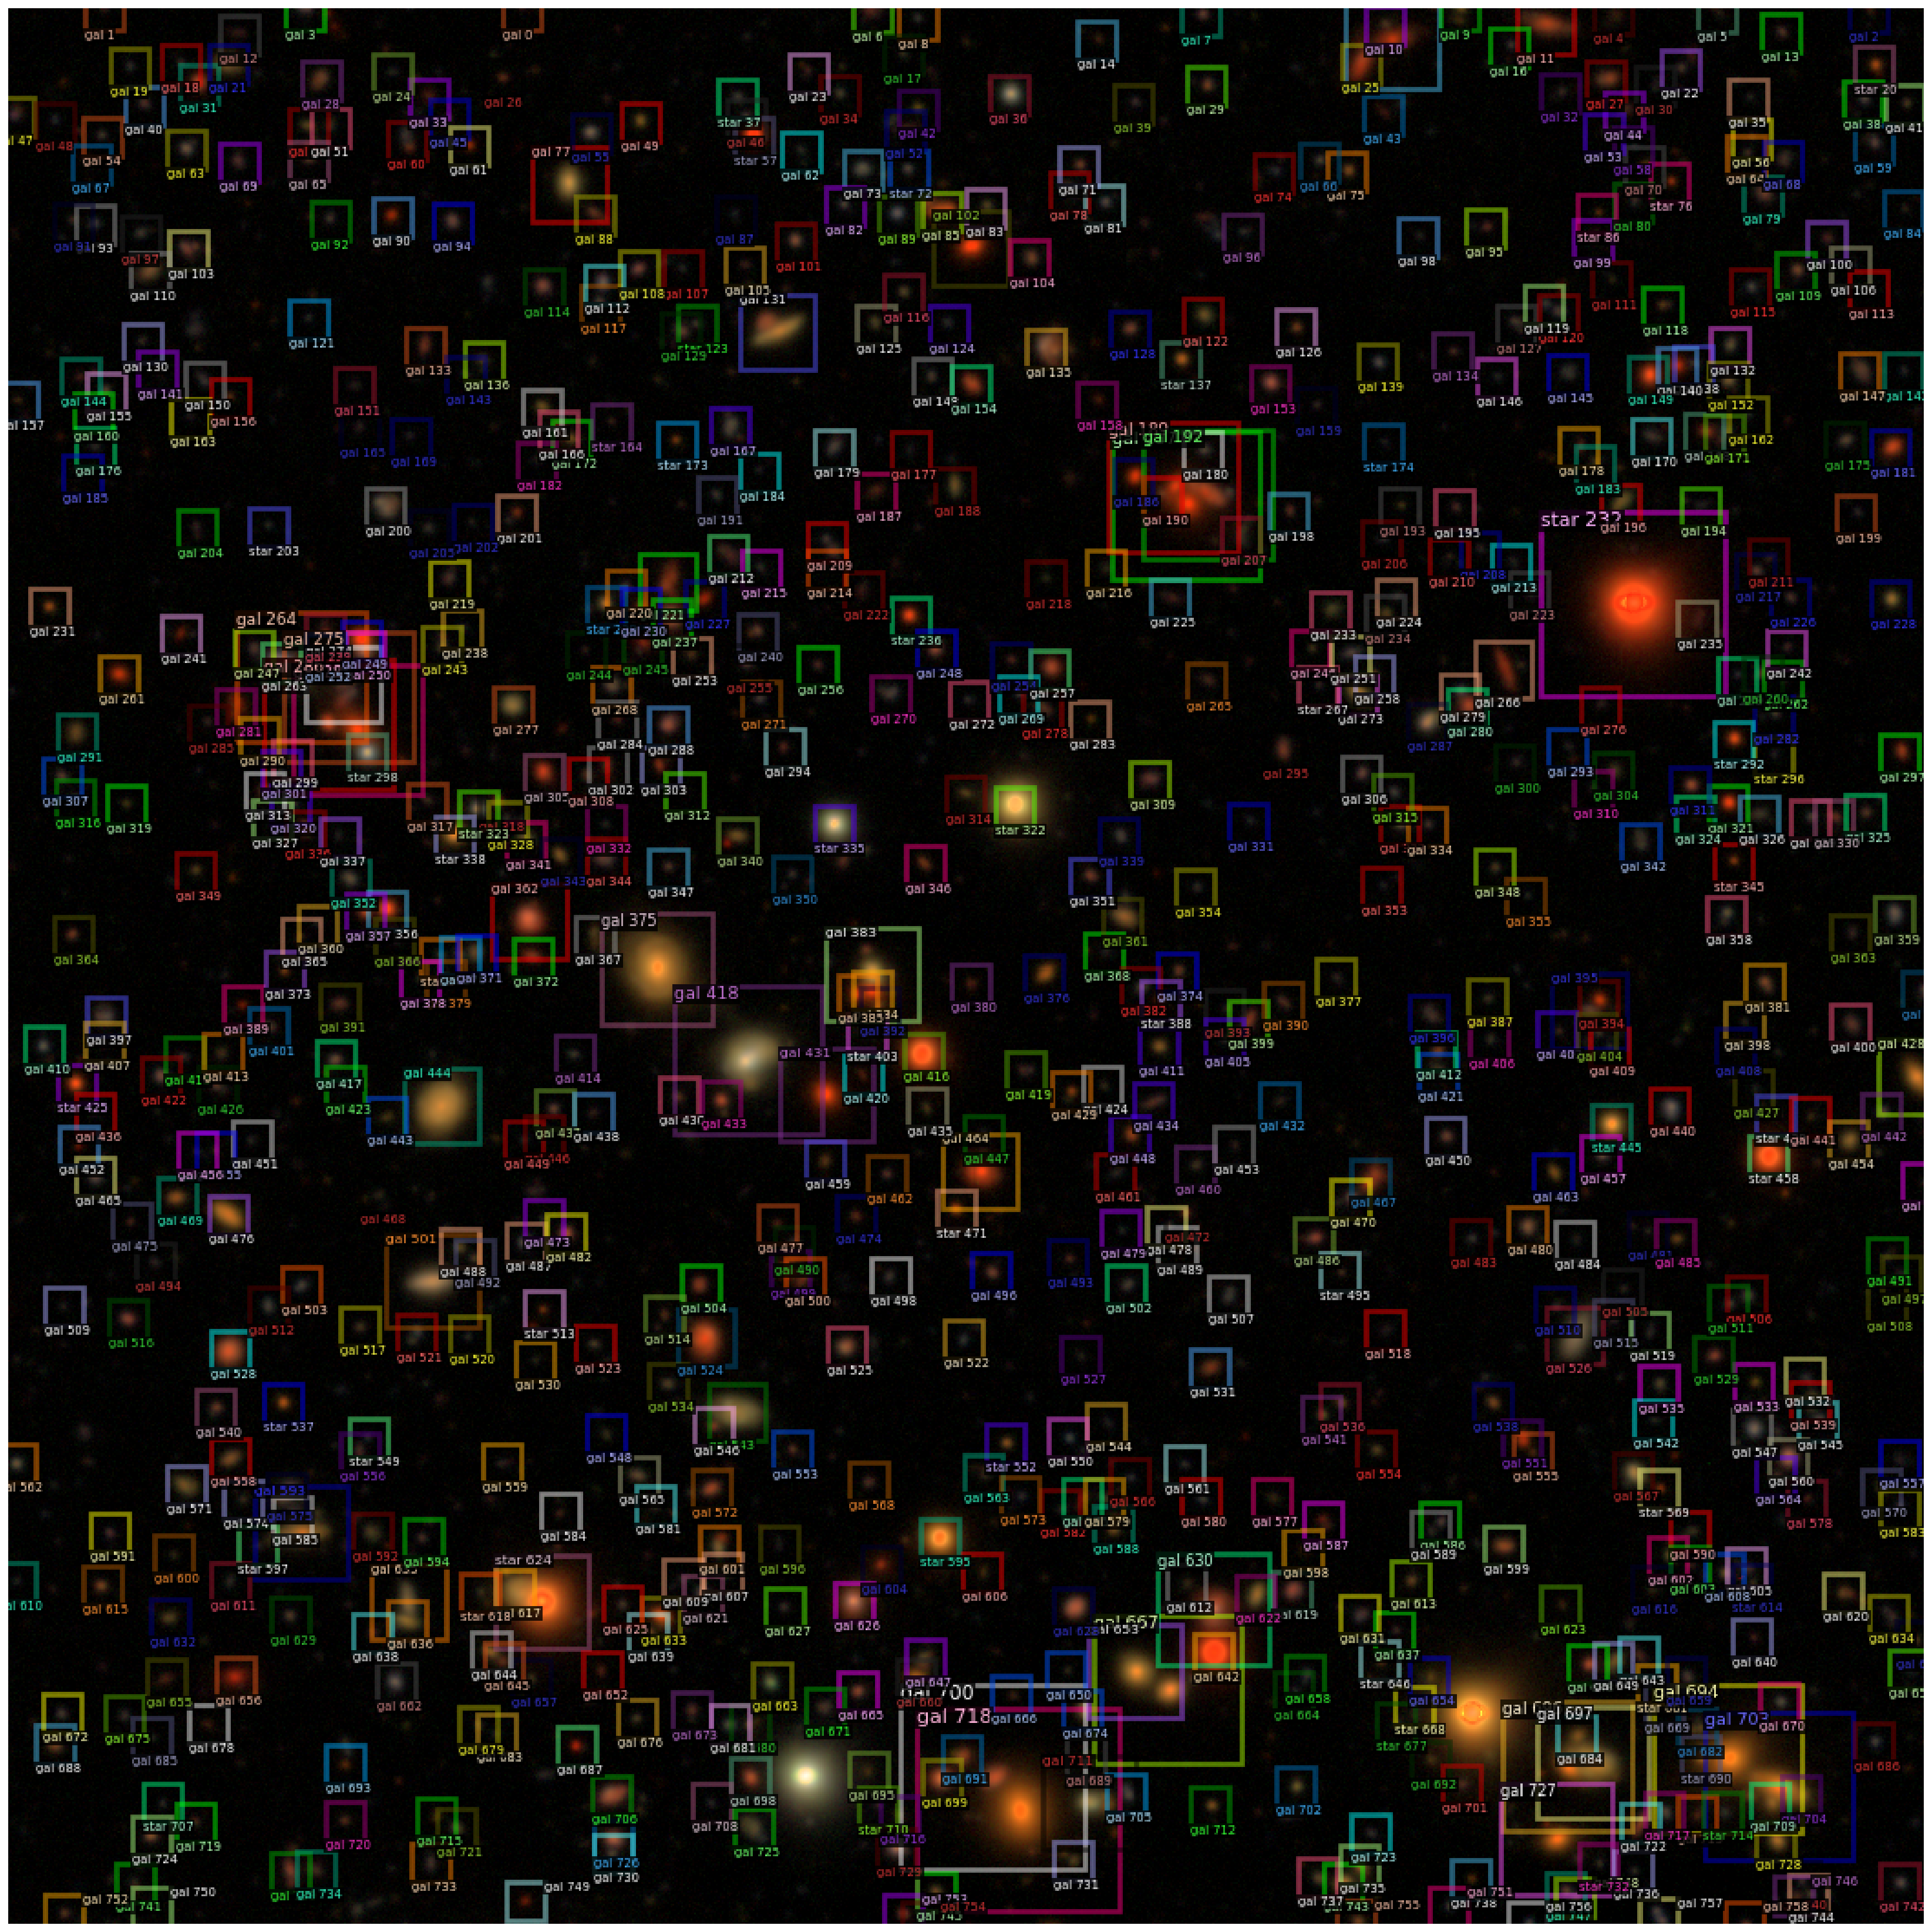

In [26]:
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode
from astrodet.visualizer import Visualizer

nsample=1
q=0

fig = plt.figure(figsize=(30,30*nsample))
filenames = [single_dect_dict[0]['filename_G'],single_dect_dict[0]['filename_R'],single_dect_dict[0]['filename_I']]
print(filenames)

img = toolkit.read_image_hsc(filenames, normalize="astrolupton", stretch=0.5, Q=10)
visualizer = Visualizer(img,instance_mode=ColorMode.SEGMENTATION)#,metadata=MetadataCatalog.get("astro_train").set(thing_classes=["star", "galaxy","other"]))
gt_boxes = np.array([a['bbox'] for a in single_dect_dict[0]['annotations']])
labels = np.array([a['category_id'] for a in single_dect_dict[0]['annotations']])
labels_names = []
for j,label in enumerate(labels):
    if label==0:
        labels_names.append("star %d" %j)
        #labels_names.append('star')
    elif label==1:
        labels_names.append("gal %d" %j)
        #labels_names.append('galaxy')
    elif label==2:
        labels_names.append("bad fit")
    elif label==-1:
        labels_names.append("unknown %d" %j)
# Convert to the mode visualizer expects
gt_boxes = BoxMode.convert(gt_boxes, BoxMode.XYWH_ABS, BoxMode.XYXY_ABS)

#out = visualizer.draw_dataset_dict(single_dect_dict[0])
out = visualizer.overlay_instances(boxes=gt_boxes,labels=labels_names)
#out = visualizer.draw_dataset_dict(single_dect_dict[0],lf=True,boxf=True,alpha=0.01, ls='-')

ax1 = plt.subplot(1, 1, 2*q+1)
ax1.imshow(out.get_image())
ax1.axis('off')
#ax2 = plt.subplot(nsample*2, 1, 2*i+2)
#ax2.imshow(img,origin='lower')
#plt.savefig('/home/g4merz/deblend/plots/fullbox.png')